In [39]:
import numpy as np
import random
import matplotlib.pyplot as plt
import cv2
import os
import torch
from torch import nn

from torch.utils.data import DataLoader, Dataset
from pathlib import Path
from PIL import Image
import glob
import kagglehub


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

In [40]:
# Download dataset
path = kagglehub.dataset_download("prasunroy/natural-images")
print("Path to dataset files:", path)


Path to dataset files: /Users/andreakorunoska/.cache/kagglehub/datasets/prasunroy/natural-images/versions/1


#### Configurtations

In [41]:
CONFIGURATION = {
    'width': 320,
    'height': 240,
    'patch_w_h': 64,
    'max_shift': 16,
}


 ## Generate samples

#### Loading and preprocessing data

In [42]:
def load_and_preprocess(path, to_gray=True):
    img = Image.open(path).convert('RGB')
    img = img.resize((CONFIGURATION['width'], CONFIGURATION['height']), Image.BICUBIC)
    if to_gray:
        img = img.convert('L')
    return np.array(img)


#### Making a window
##### Helper functions - resize, choose window, compute homography, wrap, crop, stack

In [43]:
def sample_window_top_left(image_w, image_h):
    margin = CONFIGURATION['max_shift']
    patch = CONFIGURATION['patch_w_h']

    min_x = margin
    min_y = margin
    max_x = image_w - patch - margin
    max_y = image_h - patch - margin

    x = random.randint(min_x, max_x)
    y = random.randint(min_y, max_y)
    return x, y


In [44]:
def window_corners(x,y):
    p = CONFIGURATION['patch_w_h']
    return np.array([
        [x,     y],
        [x+p-1, y],
        [x+p-1, y+p-1],
        [x,     y+p-1]
    ], dtype=np.float32)


In [45]:
def perturb_corners(corners):
    shift = CONFIGURATION['max_shift']
    perturb = np.random.randint(-shift, shift+1, size=corners.shape)
    return (corners + perturb).astype(np.float32)


In [46]:
def compute_homography(src_pts, dst_pts):
    return cv2.getPerspectiveTransform(src_pts, dst_pts)

def wrap_image_apply_inverse(image, H):
    H_inv = np.linalg.inv(H)
    w, h = CONFIGURATION['width'], CONFIGURATION['height']
    wrapped = cv2.warpPerspective(
        image,
        H_inv,
        (w, h),
        flags=cv2.INTER_LINEAR,
        borderMode=cv2.BORDER_REPLICATE
    )
    return wrapped


In [47]:
def crop_patch(image, x, y):
    p = CONFIGURATION['patch_w_h']
    return image[y:y+p, x:x+p].copy()


In [48]:
def make_2_channel_sample(original_image, warped_image, x, y):
    p1 = crop_patch(original_image, x, y)
    p2 = crop_patch(warped_image, x, y)

    p1 = p1.astype(np.float32) / 255.0
    p2 = p2.astype(np.float32) / 255.0

    # Output shape (64,64,2)
    return np.stack([p1, p2], axis=-1)


#### Generate sample

In [49]:
def generate_sample_from_image(img_arr):
    H_img, W_img = img_arr.shape[:2]

    x, y = sample_window_top_left(W_img, H_img)
    src = window_corners(x, y)
    dst = perturb_corners(src)

    H = compute_homography(src, dst)
    warped_full = wrap_image_apply_inverse(img_arr, H)

    sample_patch = make_2_channel_sample(img_arr, warped_full, x, y)

    return {
        "sample": sample_patch,
        "H": H,
        "src_corners": src,
        "dst_corners": dst,
        "orig_patch": crop_patch(img_arr, x, y),
        "warped_patch": crop_patch(warped_full, x, y)
    }


In [50]:
class HomographyDataset(Dataset):
    def __init__(self, image_paths, samples_per_image=50):
        self.image_paths = image_paths
        self.samples_per_image = samples_per_image
        self.index = []
        for p in image_paths:
            for _ in range(samples_per_image):
                self.index.append(p)
        random.shuffle(self.index)

    def __len__(self):
        return len(self.index)

    def __getitem__(self, idx):
        p = self.index[idx]
        img = load_and_preprocess(p)

        data = generate_sample_from_image(img)

        sample = data["sample"].transpose(2, 0, 1)  # (2, H, W)
        sample_t = torch.from_numpy(sample)

        src = data["src_corners"].reshape(-1)
        dst = data["dst_corners"].reshape(-1)
        offset = (dst - src).astype(np.float32)

        return {
            "input": sample_t,
            "offset": torch.from_numpy(offset),
            "H": torch.from_numpy(data["H"])
        }


In [51]:
dataset_path = path
print(os.listdir(dataset_path))

image_files = glob.glob(dataset_path + "/**/*.jpg", recursive=True)
print("Found", len(image_files), "images.")


['natural_images', 'data']
Found 13798 images.


In [52]:
ds = HomographyDataset(image_files, samples_per_image=20)
loader = DataLoader(ds, batch_size=16, shuffle=True, num_workers=0)


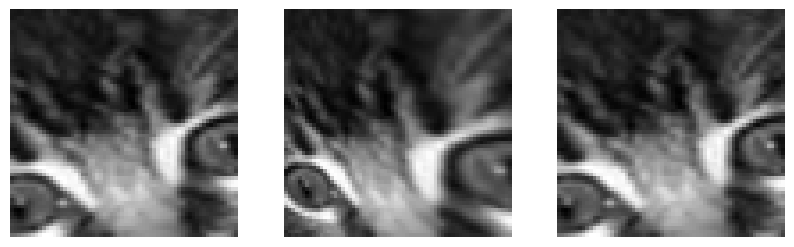

In [73]:
def show_sample_dict(d):
    fig, axs = plt.subplots(1, 3, figsize=(10,4))
    axs[0].imshow(d["orig_patch"], cmap="gray")
    axs[1].imshow(d["warped_patch"], cmap="gray")
    axs[2].imshow(d["sample"][:,:,0], cmap="gray")
    for a in axs: a.axis("off")
    plt.show()

example = generate_sample_from_image(load_and_preprocess(image_files[0]))
show_sample_dict(example)


### Neural network

In [ ]:
class ResNetBlock(nn.Module):
    def __init__(self, input_channels, output_channels):
        super().__init__()
        self.convolution1 = nn.Conv2d(input_channels, output_channels, kernel_size=3, padding=1, bias=False)
        self.normalization1 = nn.BatchNorm2d(output_channels)
        self.convolution2 = nn.Conv2d(input_channels, output_channels, kernel_size=3, padding=1, bias=False)
        self.normalization2 = nn.BatchNorm2d(output_channels)

        if input_channels != output_channels:
            self.identity = nn.Conv2d(input_channels, output_channels, kernel_size=1, padding='same', stride=1)
        else:
            self.identity = nn.Identity()

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        identity = self.identity(x)
        out = self.convolution1(x)
        out = self.normalization1(out)
        out = self.relu(out)
        out = self.convolution2(out)
        out = self.normalization2(out)
        out += identity
        out = self.relu(out)

        return out

### todo do i need to implement with downsample or is this oaky

In [ ]:
class HomographyLayer(nn.Module):
    def __init__(self, input_channels):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(input_channels, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )

        self.stage1 = nn.Sequential(
            ResNetBlock(64, 64),
            ResNetBlock(64, 64),
            nn.MaxPool2d(2)
        )

        self.stage2 = nn.Sequential(
            ResNetBlock(64, 64),
            ResNetBlock(64, 64),
            nn.MaxPool2d(2)
        )

        self.convolution_upsample = nn.Conv2d(64, 128, kernel_size=1, bias=False)
        self.stage3 = nn.Sequential(
            ResNetBlock(128, 128),
            ResNetBlock(128, 128),
            nn.MaxPool2d(2)
        )

        self.stage4 = nn.Sequential(
            ResNetBlock(128, 128),
            ResNetBlock(128, 128),
        )

        ## todo how are we handling hte calculations
        feat_map_h = CONFIGURATION['patch_w_h'] // (2*2*2)  # 64 -> 8
        feat_map_w = feat_map_h
        feat_channels = 128
        feat_dim = feat_channels * feat_map_h * feat_map_w  # 128*8*8 = 8192
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(feat_dim, 512),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # x: (B, C=2, H=64, W=64) expected
        out = self.initial(x)
        out = self.stage1(out)
        out = self.stage2(out)
        out = self.conv_up3(out)
        out = self.stage3(out)
        out = self.stage4(out)
        out = self.fc(out)  # (B, 512)
        return out

In [ ]:
class RegressionHead(nn.Module):
    def __init__(self, in_dim=512, out_dim=8):
        super().__init__()
        self.fc = nn.Linear(in_dim, out_dim)

    def forward(self, x):
        return self.fc(x)


class ClassificationHead(nn.Module):
    def __init__(self, in_dim=512, bins=21):
        super().__init__()
        self.bins = bins
        self.fc = nn.Linear(in_dim, 8 * bins)

    def forward(self, x):
        logits = self.fc(x)
        logits = logits.view(-1, 8, self.bins)
        return logits


In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self, head_type='regression', bins=21):
        super().__init__()
        assert head_type in ('regression', 'classification')
        self.backbone = HomographyLayer(in_ch=2)
        if head_type == 'regression':
            self.head = RegressionHead(in_dim=512, out_dim=8)
        else:
            self.head = ClassificationHead(in_dim=512, bins=bins)
        self.head_type = head_type

    def forward(self, x):
        feats = self.backbone(x)
        out = self.head(feats)
        return out

In [ ]:
# Binning logic for classification: map continuous offsets to 21 discrete classes
bins = 21
max_shift = CONFIGURATION['max_shift']
bin_centers = np.linspace(-max_shift, max_shift, bins)  # 21 centers

def offsets_to_class_indices(offsets):
    offs = np.asarray(offsets)
    flat = offs.reshape(-1)  # flatten
    diffs = np.abs(flat[:, None] - bin_centers[None, :])  # (N, bins)
    idx = np.argmin(diffs, axis=1)
    return idx.reshape(offs.shape).astype(np.int64)

def class_indices_from_torch(offset_tensor):
    np_offs = offset_tensor.cpu().numpy()
    return offsets_to_class_indices(np_offs)  # numpy (B,8)


In [ ]:
mse_loss = nn.MSELoss()

def regression_loss(pred, target):
    # pred, target: tensors shape (B,8)
    return torch.sqrt(mse_loss(pred, target) + 1e-8)  # RMSE (scalar)

ce_loss = nn.CrossEntropyLoss(reduction='mean')

def classification_loss(logits, target_indices):
    """
    logits: (B,8,bins)
    target_indices: numpy or tensor shape (B,8) with int class ids
    We'll compute CE across bins for each of the 8 corners and average.
    """
    if isinstance(target_indices, np.ndarray):
        target_indices = torch.from_numpy(target_indices).to(logits.device)
    B = logits.shape[0]
    # Reshape to (B*8, bins) and (B*8,) targets
    logits_flat = logits.view(-1, logits.shape[-1])
    targets_flat = target_indices.view(-1)
    loss = ce_loss(logits_flat, targets_flat)
    return loss

def classification_accuracy(logits, target_indices):
    # logits: (B,8,bins), target_indices: (B,8)
    preds = logits.argmax(dim=-1).cpu().numpy()  # (B,8)
    tgt = np.array(target_indices)
    correct = (preds == tgt).astype(np.int32)
    # corner-wise accuracy and full-sample exact matches
    corner_acc = correct.mean()
    exact_match = (correct.sum(axis=1) == 8).mean()
    return corner_acc, exact_match
